In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import get_img_obj_points
from utils import cal_undistort
from utils import *

import numpy as np
import glob
# Read in an image

fnames = glob.glob("camera_cal/*.jpg")

img_points_list = []
obj_points_list = []
for fname in fnames :
    img = cv2.imread(fname)
    nx = 9  # the number of inside corners in x
    ny = 6  # the number of inside corners in y
    img_points, obj_points = get_img_obj_points(img, nx, ny)
    img_points_list+=img_points
    obj_points_list+=obj_points



# Undistort

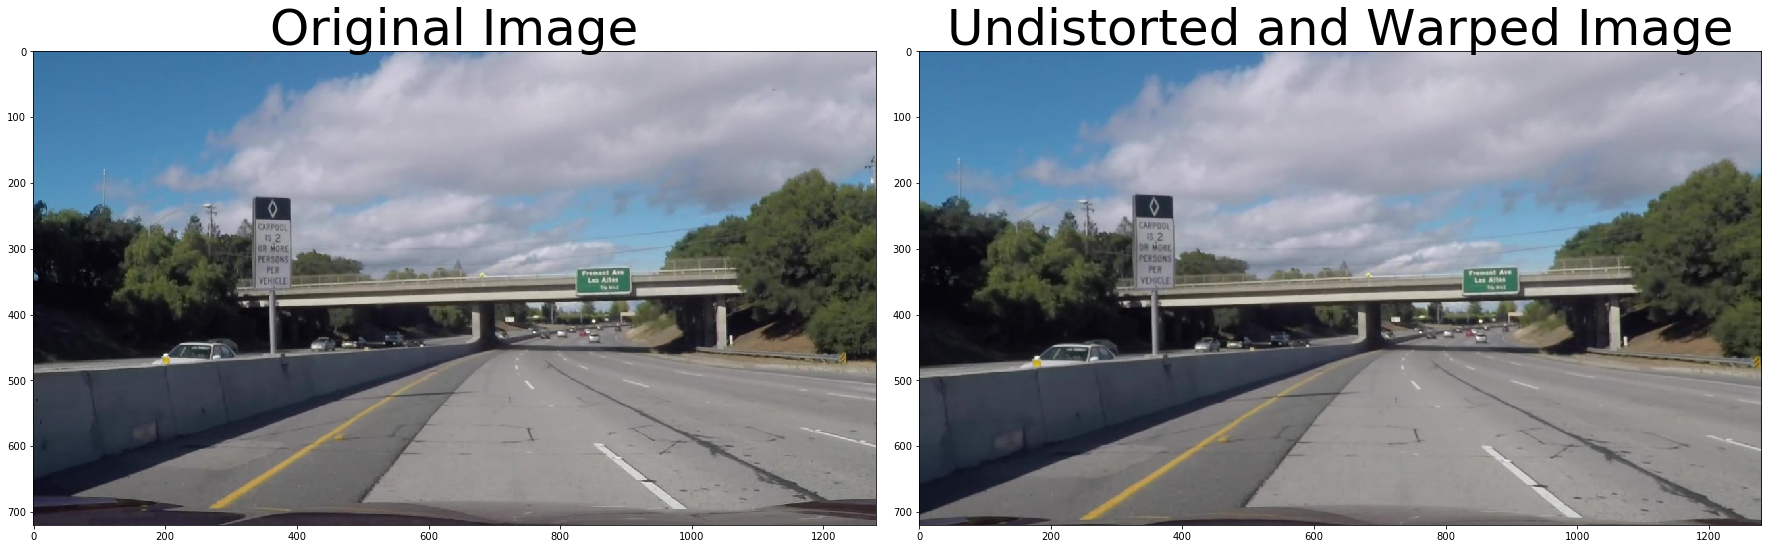

In [2]:
img = mpimg.imread('challenge_video_Moment.jpg')
height, width  = img.shape[0], img.shape[1]
undistorted, dist, mtx = cal_undistort(img, obj_points_list, img_points_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Sobel filters

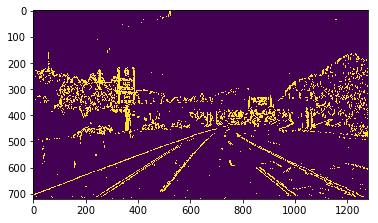

In [3]:


image = undistorted.copy()
combined = np.zeros((height,width), dtype = np.uint8)
combined_condition = sobel_filter(image)
combined[combined_condition] = 1
plt.imshow(combined)
plt.show()

# RGB Filter

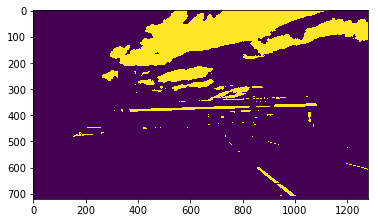

In [4]:


rgb = np.copy(undistorted)
color_combined = np.zeros((height,width), dtype = np.uint8)
r_g_condition = rgb_filter(rgb)
color_combined[r_g_condition] = 1
plt.imshow(color_combined)
plt.show()


# HLS filter

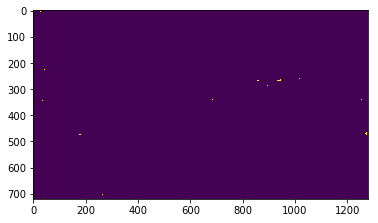

In [5]:



img = np.copy(undistorted)
s_binary = np.zeros((height,width), dtype = np.uint8)
s_binary_condition = hls_filter(img)
s_binary[s_binary_condition] = 1
plt.imshow(s_binary)
plt.show()

YUV

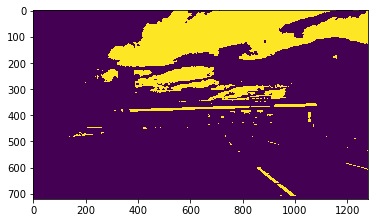

In [6]:


img = np.copy(undistorted)
yuv = np.zeros((height,width), dtype = np.uint8)
yuv_condition = yuv_filter(img)
yuv[yuv_condition] = 1
plt.imshow(yuv)
plt.show()

# HSV

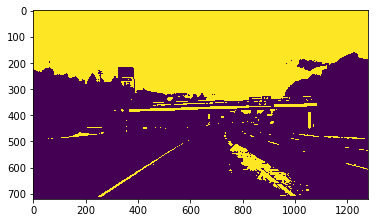

In [7]:

img = np.copy(undistorted)
hsv = np.zeros((height,width), dtype = np.uint8)
hsv_condition = hsv_filter(img)
hsv[hsv_condition] = 1
plt.imshow(hsv)
plt.show()



# Combined

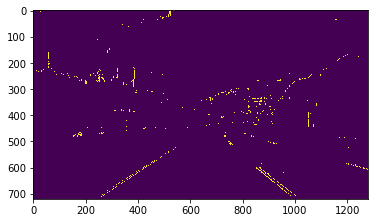

In [8]:
# Combine the two binary thresholds
combined_binary = np.zeros((height,width), dtype = np.uint8)
combined_binary[(r_g_condition | yuv_condition | hsv_condition) & (s_binary_condition | combined_condition )] = 1
plt.imshow(combined_binary)
plt.show()

# Region of intersect

In [9]:

# # apply the region of interest mask
# mask = np.zeros_like(combined_binary)
# region_of_intersect = np.array([[0,height], [width/2, int(0.5*height)], [width, height]], dtype=np.int32)
# cv2.fillPoly(mask, [region_of_intersect], 1)
# thresholded = cv2.bitwise_and(combined_binary, mask)

# plt.imshow(thresholded)
# plt.show()

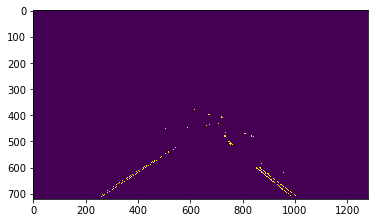

In [10]:
from utils import filter_image
filtered_image = filter_image(undistorted.copy())
plt.imshow(filtered_image)
plt.show()

# Perspective Transform

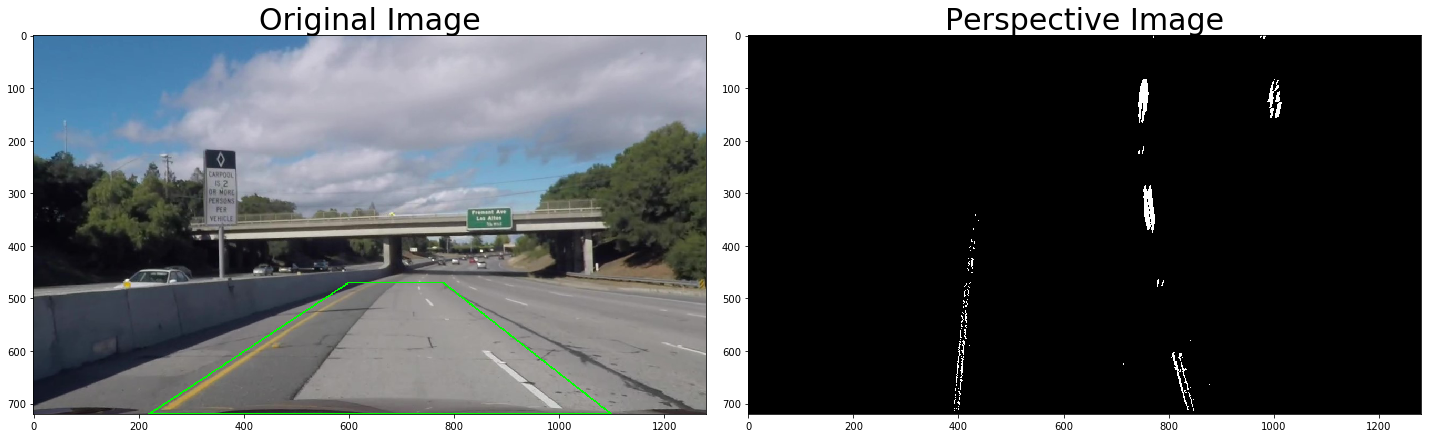

In [11]:
# # Vertices extracted manually for performing a perspective transform
warped, filled = perspective_transform_with_filled_area(img.copy(), filtered_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(filled)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Perspective Image', fontsize=30)
plt.show()


#### 

360


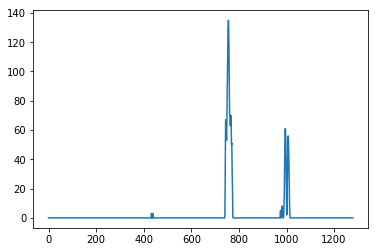

In [12]:
print(warped.shape[0]//2)
histogram = np.sum(warped[:warped.shape[0]//2,:], axis=0)
plt.plot(histogram)
plt.show()



(720, 0)

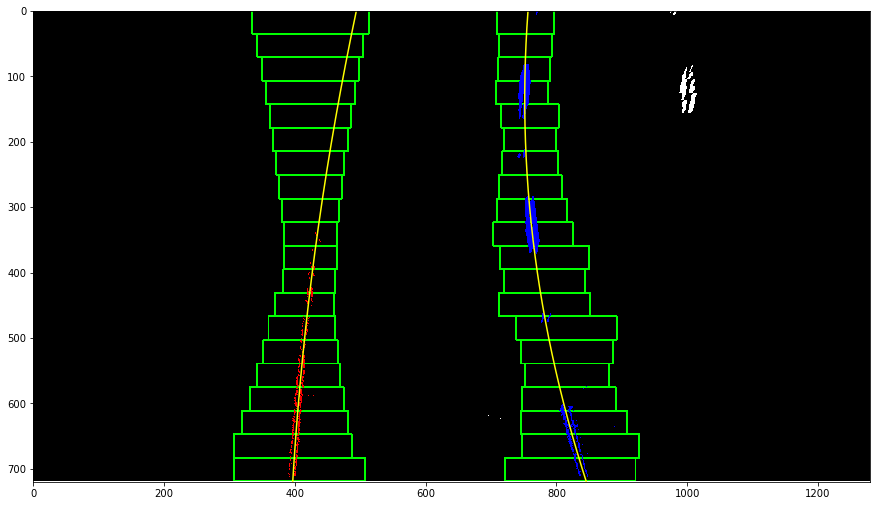

In [13]:
ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = get_lane_rectangles(warped)

# Generate x and y values for plotting

plt.figure(figsize=(15,15))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



(720, 0)

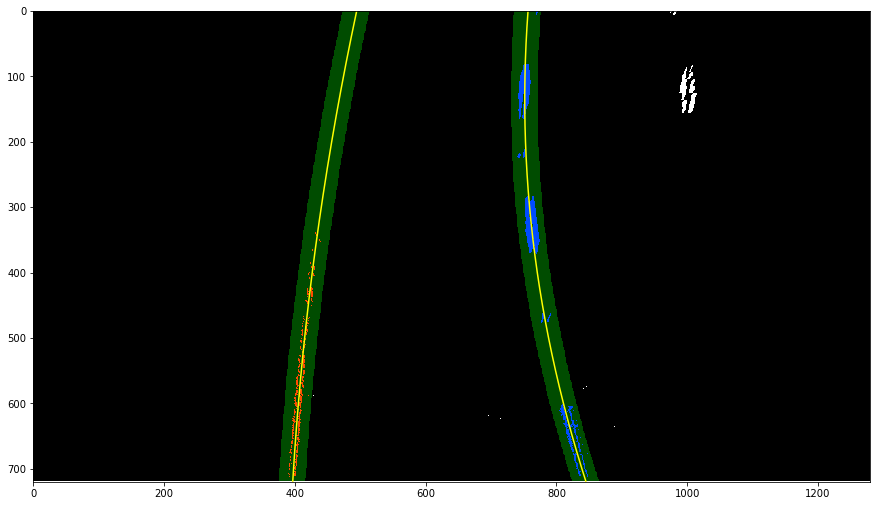

In [14]:
result, ploty, left_fitx, right_fitx, left_fit, right_fit, is_blind = get_next_frame_lines(warped, left_fit, right_fit)
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [15]:
left_rad_curvature = get_curvature_radius(left_fit, ploty)
right_rad_curvature = get_curvature_radius(right_fit, ploty)
avg_rad_curvature = (left_rad_curvature+right_rad_curvature)/2
print('radius : ', avg_rad_curvature)

radius :  1071.2712568352827


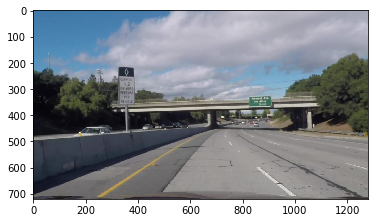

In [16]:
plt.imshow(img)
plt.show()

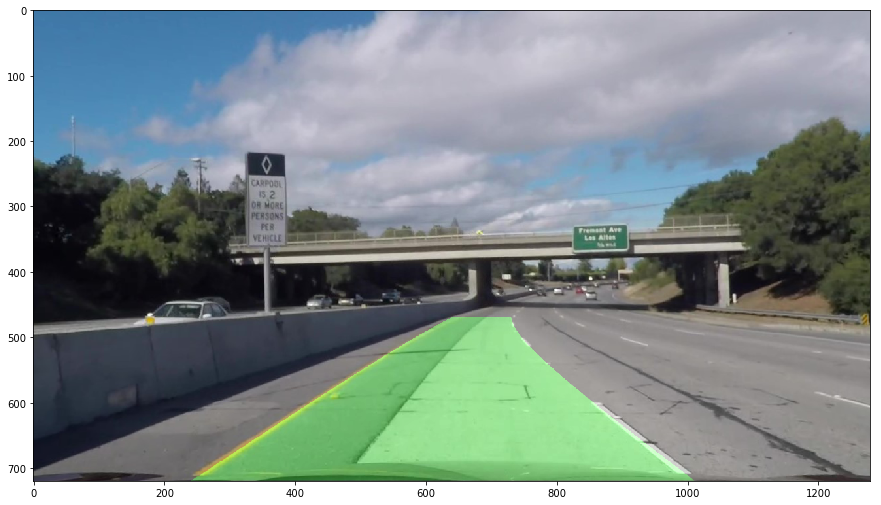

In [17]:
result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)
plt.figure(figsize=(15, 15))
plt.imshow(result)

In [18]:
def pipeline_final(img):

    global caches 
    
    is_blind = False
    
    if caches:
        left_fit, right_fit, is_blind  = caches
        filtered_image = filter_image(img, is_blind)
    else:
        filtered_image = filter_image(img)
        left_fit, right_fit = None, None
        
    warped, filled = perspective_transform_with_filled_area(img, filtered_image)
    

    ploty, left_fitx, right_fitx, left_fit, right_fit, deep_search = get_lane_rectangles(warped, left_fit, right_fit, is_blind)
    if not caches : 
        caches = [left_fit, right_fit, is_blind]

    if caches : 
        left_fit, right_fit, is_blind  = caches
        out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, is_blind = get_next_frame_lines(warped, left_fit, right_fit, is_blind)
        caches = [left_fit, right_fit, is_blind]

            

    result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)

    left_rad_curvature = get_curvature_radius(left_fit, ploty)
    right_rad_curvature = get_curvature_radius(right_fit, ploty)
    avg_rad_curvature = (left_rad_curvature+right_rad_curvature)/2
    radius_text = "Curvature radius : " + str(int(avg_rad_curvature)) + "m"

    result  = add_diagnostic_image(result, filtered_image, 0)
    result  = add_diagnostic_image(result, warped, 1)
    result  = add_diagnostic_image(result, deep_search, 2)
    result  = add_diagnostic_image(result, out_img, 3)
    result  = add_diagnostic_text(result, radius_text, 5, offset=150)

    return result

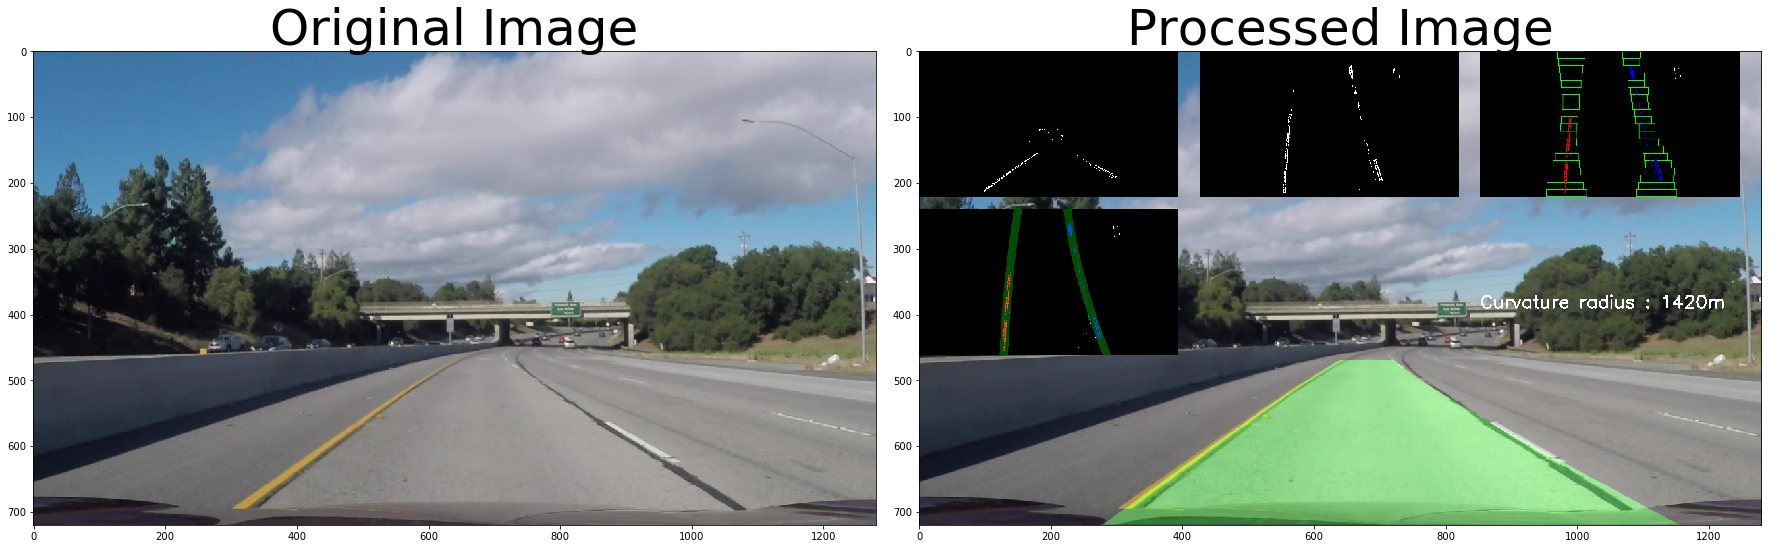

In [19]:
img = mpimg.imread('Challenge_video_Moment4.jpg')

# Reinitialize some global variables.
caches = []

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
# from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip

# Reinitialize some global variables.
caches = [] 

polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'zzz3.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video zzz3.mp4
[MoviePy] Writing video zzz3.mp4


  3%|▎         | 36/1261 [00:03<01:58, 10.30it/s]

KeyboardInterrupt: 

  3%|▎         | 36/1261 [00:20<11:20,  1.80it/s]